In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Modified from https://github.com/rasbt/deeplearning-models/blob/master/pytorch_ipynb/transfer/transferlearning-vgg16-cifar10-1.ipynb

import torch
import time
import numpy as np
np.random.seed(0)

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

#######################################
### PRE-TRAINED MODELS AVAILABLE HERE
## https://pytorch.org/docs/stable/torchvision/models.html
from torchvision import models
#######################################


import matplotlib.pyplot as plt 
%matplotlib inline

cuda = torch.cuda.is_available()

torch.manual_seed(0)
if cuda:
    torch.cuda.manual_seed(0)
    torch.backends.cudnn.deterministic = True

In [3]:
# Device
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', DEVICE)

Device: cuda:0


In [4]:
NUM_CLASSES = 10

# Hyperparameters
random_seed = 1
learning_rate = 0.0001
num_epochs = 10
batch_size = 128

In [5]:
##########################
### CIFAR-10 DATASET
##########################

custom_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
])

## Note that this particular normalization scheme is
## necessary since it was used for pre-training
## the network on ImageNet.
## These are the channel-means and standard deviations
## for z-score normalization.


train_dataset = datasets.CIFAR10(root='data', 
                                 train=True, 
                                 transform=custom_transform,
                                 download=True)

test_dataset = datasets.CIFAR10(root='data', 
                                train=False, 
                                transform=custom_transform)


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          num_workers=8,
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size, 
                         num_workers=8,
                         shuffle=False)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Files already downloaded and verified
Image batch dimensions: torch.Size([128, 3, 224, 224])
Image label dimensions: torch.Size([128])


In [6]:
# get some random training images
x, y = next(iter(train_loader))
x.shape, y.shape

(torch.Size([128, 3, 224, 224]), torch.Size([128]))

In [7]:
def unnormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor


def imshow(img, label):
    
    # Unnormalize
    img = unnormalize(img, torch.tensor([0.485, 0.456, 0.406]), 
                                        torch.tensor([0.229, 0.224, 0.225]))
    
    # Convert to numpy
    img = img.numpy()
    
    classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    # Plot
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.title("This is a {}".format(classes[label]))

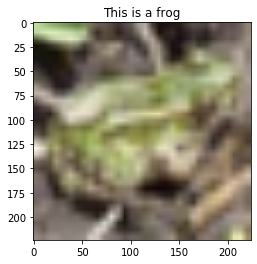

In [8]:
ct = 25
imshow(x[ct], y[ct])

In [9]:
# Get VGG16 from https://pytorch.org/docs/stable/torchvision/models.html

model = models.vgg16(pretrained=True)
#model = models.resnet18(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/hasib/.cache/torch/checkpoints/vgg16-397923af.pth
100.0%


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [10]:
# All parameters
all_params = sum(p.numel() for p in model.parameters())
print("All parameters ", all_params)

# Trainable parameters
all_train_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Trainable parameters ", all_train_params)

All parameters  138357544
Trainable parameters  138357544


In [11]:
# Freeze whole model
for param in model.parameters():
    param.requires_grad = False

In [12]:
# Unfreeze second last layer
# (3): Linear(in_features=4096, out_features=4096, bias=True)

model.classifier[3].requires_grad = True

In [13]:
model.classifier[6] = nn.Sequential(
                      nn.Linear(4096, 512), 
                      nn.ReLU(), 
                      nn.Dropout(0.5),
                      nn.Linear(512, NUM_CLASSES))

In [14]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [16]:
# Send model to GPU
model = model.to(DEVICE)

# Init optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [17]:
def compute_accuracy(model, data_loader):
    model.eval()
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)

        logits = model(features)
        _, predicted_labels = torch.max(logits, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100


def compute_epoch_loss(model, data_loader):
    model.eval()
    curr_loss, num_examples = 0., 0
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.to(DEVICE)
            targets = targets.to(DEVICE)
            logits = model(features)
            loss = F.cross_entropy(logits, targets, reduction='sum')
            num_examples += targets.size(0)
            curr_loss += loss

        curr_loss = curr_loss / num_examples
        return curr_loss

In [18]:
start_time = time.time()
for epoch in range(num_epochs):
    
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
            
        ### FORWARD AND BACK PROP
        logits = model(features)
        loss = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        loss.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %04d/%04d | Loss: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), loss))

    model.eval()
    with torch.set_grad_enabled(False): # save memory during inference
        print('Epoch: %03d/%03d | Train: %.3f%% | Loss: %.3f' % (
              epoch+1, num_epochs, 
              compute_accuracy(model, train_loader),
              compute_epoch_loss(model, train_loader)))


    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/010 | Batch 0000/0391 | Loss: 2.3378
Epoch: 001/010 | Batch 0050/0391 | Loss: 0.9998
Epoch: 001/010 | Batch 0100/0391 | Loss: 0.8522
Epoch: 001/010 | Batch 0150/0391 | Loss: 0.6991
Epoch: 001/010 | Batch 0200/0391 | Loss: 0.7464
Epoch: 001/010 | Batch 0250/0391 | Loss: 0.6865
Epoch: 001/010 | Batch 0300/0391 | Loss: 0.8010
Epoch: 001/010 | Batch 0350/0391 | Loss: 0.6725
Epoch: 001/010 | Train: 82.232% | Loss: 0.521
Time elapsed: 12.27 min
Epoch: 002/010 | Batch 0000/0391 | Loss: 0.6319
Epoch: 002/010 | Batch 0050/0391 | Loss: 0.7577
Epoch: 002/010 | Batch 0100/0391 | Loss: 0.6483
Epoch: 002/010 | Batch 0150/0391 | Loss: 0.6212
Epoch: 002/010 | Batch 0200/0391 | Loss: 0.5451
Epoch: 002/010 | Batch 0250/0391 | Loss: 0.5393
Epoch: 002/010 | Batch 0300/0391 | Loss: 0.6593
Epoch: 002/010 | Batch 0350/0391 | Loss: 0.5923
Epoch: 002/010 | Train: 83.642% | Loss: 0.477
Time elapsed: 24.52 min
Epoch: 003/010 | Batch 0000/0391 | Loss: 0.5520
Epoch: 003/010 | Batch 0050/0391 | Loss: 0.5

In [19]:
# Compute test accuracy
with torch.set_grad_enabled(False): # save memory during inference
    print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader)))

Test accuracy: 84.18%


In [20]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

for batch_idx, (features, targets) in enumerate(test_loader):

    features = features
    targets = targets
    break

logits = model(features.to(DEVICE))
_, predicted_labels = torch.max(logits, 1)

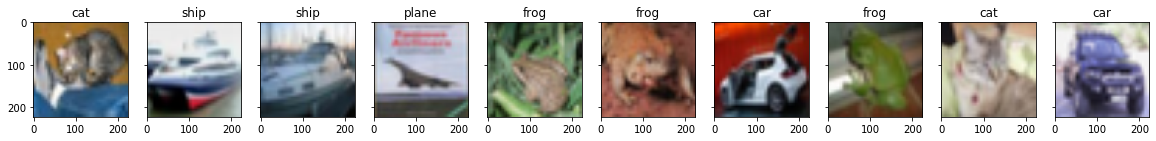

In [21]:
def unnormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

n_images = 10

fig, axes = plt.subplots(nrows=1, ncols=n_images, 
                         sharex=True, sharey=True, figsize=(20, 2.5))
orig_images = features[:n_images]

for i in range(n_images):
    curr_img = orig_images[i].detach().to(torch.device('cpu'))
    curr_img = unnormalize(curr_img,
                           torch.tensor([0.485, 0.456, 0.406]),
                           torch.tensor([0.229, 0.224, 0.225])) 
    curr_img = curr_img.permute((1, 2, 0))
    axes[i].imshow(curr_img)
    axes[i].set_title(classes[predicted_labels[i]])